<a href="https://colab.research.google.com/github/CS418/group-project-jelabi/blob/main/418_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [1]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import scipy as sc
import math
import io
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sbn

import pandas as pd
!pip install sodapy
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit=200000)

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
dfOriginal.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 215 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-10-27T23:59:00.000,"{'latitude': '42.021675231', 'human_address': ...",024,077XX N MARSHFIELD AVE,1951183,42.021675231,DOMESTIC BATTERY SIMPLE,APARTMENT,2022-11-03T16:47:01.000,1,...,49,JF452232,2022,True,08B,-87.671894136,2422,BATTERY,False,12875321
1,2022-10-27T23:53:00.000,"{'latitude': '41.902923197', 'human_address': ...",012,028XX W DIVISION ST,1907857,41.902923197,RETAIL THEFT,GAS STATION,2022-11-03T16:47:01.000,24,...,26,JF452224,2022,False,06,-87.697288509,1211,THEFT,False,12874215
2,2022-10-27T23:50:00.000,"{'latitude': '41.887872453', 'human_address': ...",001,003XX E LOWER WACKER DR,1902539,41.887872453,TO VEHICLE,STREET,2022-11-03T16:47:01.000,32,...,42,JF452230,2022,False,14,-87.619550708,0114,CRIMINAL DAMAGE,False,12874108
3,2022-10-27T23:45:00.000,"{'latitude': '41.960718285', 'human_address': ...",016,005XX W OHARE ST,1928598,41.960718285,SIMPLE,PARKING LOT / GARAGE (NON RESIDENTIAL),2022-11-03T16:47:01.000,76,...,41,JF452223,2022,False,08B,-87.882620302,1654,BATTERY,False,12874165
4,2022-10-27T23:45:00.000,"{'latitude': '41.974607329', 'human_address': ...",020,012XX W Carmen Ave,1934055,41.974607329,OVER $500,DRIVEWAY - RESIDENTIAL,2022-11-03T16:47:01.000,3,...,47,JF453715,2022,False,06,-87.660635398,2033,THEFT,False,12876004


The data above is primarily a large set of reported crime incidents. It contains a variety of important attributes for each crime, including but not limited to its location, the type of crime, the timestamp, whether or not it resulted in an arrest, etc. This dataset seems to heavily focus on location interestingly enough, as it has a variety of different attributes related to it such as coordinates, address, ward number, etc.

Data Cleaning

In [2]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on']) #Cleaning by dropping unneeded columns

In [3]:
# Merging certain similar features
df.loc[df["primary_type"] == "MOTOR VEHICLE THEFT", "primary_type"] = "THEFT"
df.loc[df["primary_type"] == "CRIMINAL SEXUAL ASSAULT", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "BATTERY", "primary_type"] = "ASSAULT"
df.loc[df["primary_type"] == "CRIMINAL TRESPASS", "primary_type"] = "BURGLARY"
df.loc[df["primary_type"] == "INTERFERENCE WITH PUBLIC OFFICER", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "OBSCENITY", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "PUBLIC INDECENCY", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION", "primary_type"] = "WEAPONS VIOLATION"
df.loc[df["primary_type"] == "OTHER NARCOTIC VIOLATION", "primary_type"] = "NARCOTICS"

df.isna().sum().sum() #Drop rows with any missing values, very small amount of data


7911

Data Visualization

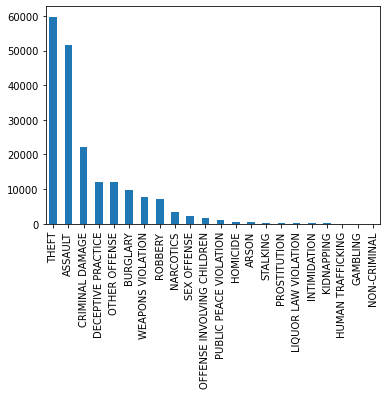

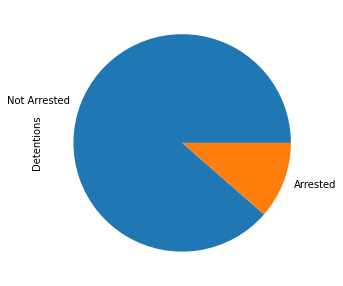

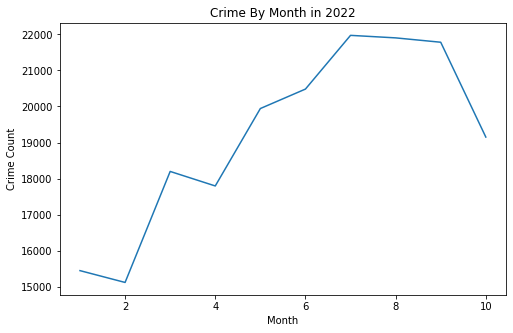

In [4]:
df['primary_type'].value_counts().plot(kind='bar')
plt.show()


arrest_df = df['arrest'].value_counts()
arrest_count = (arrest_df / df['arrest'].sum())
arrest_count.rename("Detentions",inplace=True)
arrest_count.rename({True: 'Arrested', False: 'Not Arrested'},inplace=True)
arrest_count.plot.pie(y=1, figsize=(5, 5))
plt.show()

crimeDate = df.copy(deep=True)
crimeDate.date = pd.to_datetime(crimeDate.date, format = '%Y-%m-%dT%H:%M:%S.000')
crimeDate.index = pd.DatetimeIndex(crimeDate.date)

plt.figure(figsize = (8,5))
crimeDate.groupby([crimeDate.index.month]).size().plot.line()

plt.title('Crime By Month in 2022')
plt.ylabel('Crime Count')
plt.xlabel('Month')
plt.show()

3 visualizations are listed above. Contrary to popular opinion and our hypothesis, homicide was nowhere near the top number of crimes committed in Chicago. Theft and assault accounted for a majority. 

In addition, out of most reported crimes, only about 1/8 of them resulted in arrests. We had hypothesized this, as many crimes go unsolved in Chicago.

Lastly, the final graph shows that crime rises significantly during the warmer spring and summer months, before falling in the winter and fall. This lines up with our hypothesis, as harsher weather depresses all sorts of activity. 